
Generating IID samples from the bimodal posterior...

Running MCMC sampling...
Sampling with HMC using 4 chains...


/home/fabian/anaconda3/envs/pymc_immo_env/lib/python3.12/site-packages/pytensor/tensor/rewriting/math.py:2397: RuntimeWarning: invalid value encountered in scalar subtract
  v = reduce(np.add, num, zero) - reduce(np.add, denum, zero)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mixed_normal]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


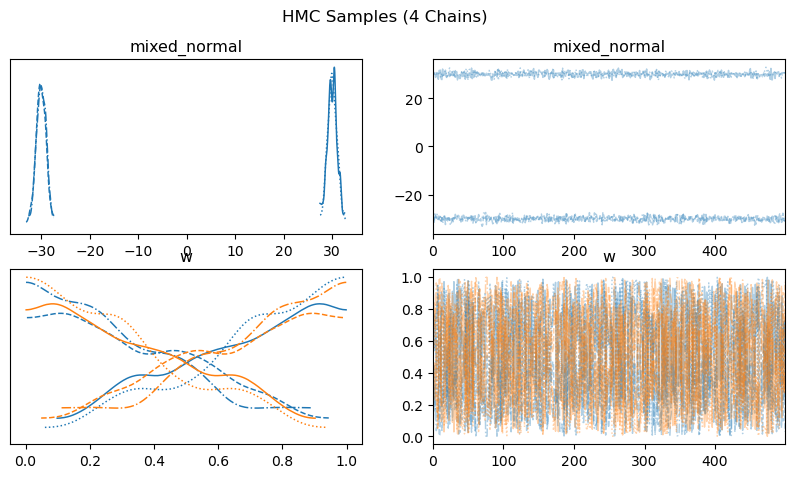


Computing pairwise Wasserstein distances...

(2000,) (2000,)
Wasserstein distance: 0.36


In [23]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as sp
import matplotlib.pyplot as plt
import itertools
from scipy.stats import gaussian_kde

class WassersteinExample:
    
    def __init__(self):
        self.model = self._bimodal_posterior()
    
    def _bimodal_posterior(self):        
        with pm.Model() as model:
            
            # Mixture weights (equal probability for both components)
            w = pm.Dirichlet("w", a=np.array([1, 1]))

            # Component distributions
            mu = pm.Normal.dist([30, -30], 1)
            
            # Mixture distribution
            mixed_normal = pm.Mixture("mixed_normal", w=w, comp_dists=mu)

        return model
    


    def generate_iid_samples(self, num_samples=2000):
        """
        Generate IID samples from the bimodal posterior directly.
        """
        print("\nGenerating IID samples from the bimodal posterior...\n")

        # Flip a coin to choose which Gaussian to sample from
        modes = np.random.choice([-30, 30], size=num_samples)
        
        # Sample from N(mode, 1)
        iid_samples = np.random.normal(loc=modes, scale=1, size=num_samples)

        return iid_samples
    

    

    def run_sampling(self, num_samples=2000, tune=1000, num_chains=2):

        with self.model:
            print("Running MCMC sampling...")

            print(f"Sampling with HMC using {num_chains} chains...")


            # Define custom initial values for 4 chains
            initvals = [
                {"w": np.array([0.9, 0.1]), "mixed_normal": 30.0},  # Chain 1 starts near Mode 2
                {"w": np.array([0.9, 0.1]), "mixed_normal": 30.0},  # Chain 2 starts near Mode 2
                {"w": np.array([0.1, 0.9]), "mixed_normal": -30.0}, # Chain 3 starts near Mode 2
                {"w": np.array([0.1, 0.9]), "mixed_normal": -30.0}, # Chain 4 starts near Mode 2
            ]

            step = pm.Metropolis()
            trace = pm.sample(num_samples, tune=tune, chains=num_chains, initvals= initvals, return_inferencedata=True, progressbar=True)
        
            az.plot_trace(trace, figsize=(10, 5))
            plt.suptitle(f"HMC Samples ({num_chains} Chains)")
            plt.show()
        
        return trace
    


    def compute_wasserstein_distances(self, trace, iid_samples):
        
        print("\nComputing pairwise Wasserstein distances...\n")


        print(iid_samples.shape, trace.posterior["mixed_normal"].values.flatten().shape)
        ws_distance = sp.wasserstein_distance(trace.posterior["mixed_normal"].values.flatten(), iid_samples)



        return ws_distance

# Instantiate framework
framework = WassersteinExample()

# Generate IID samples
iid_samples = framework.generate_iid_samples()

# Run MCMC sampling with multiple chains (e.g., num_chains=4)
trace = framework.run_sampling(num_samples=500, num_chains=4)

wasserstein_results = framework.compute_wasserstein_distances(trace, iid_samples)

print(f"Wasserstein distance: {wasserstein_results:.2f}")

